## Import libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

## Load data

In [ ]:
spiketrain = pd.read_csv("/content/drive/MyDrive/spiketrain_example.csv")

In [ ]:
spiketrain.head()

,Unnamed: 0,Time (s)
0,0,1.35040
1,1,1.52336
2,2,1.56696
3,3,2.59712
4,4,2.74472


## Visualize data
Data are spike times of action potentials detected by a single electrode.

(210.0, 250.0)

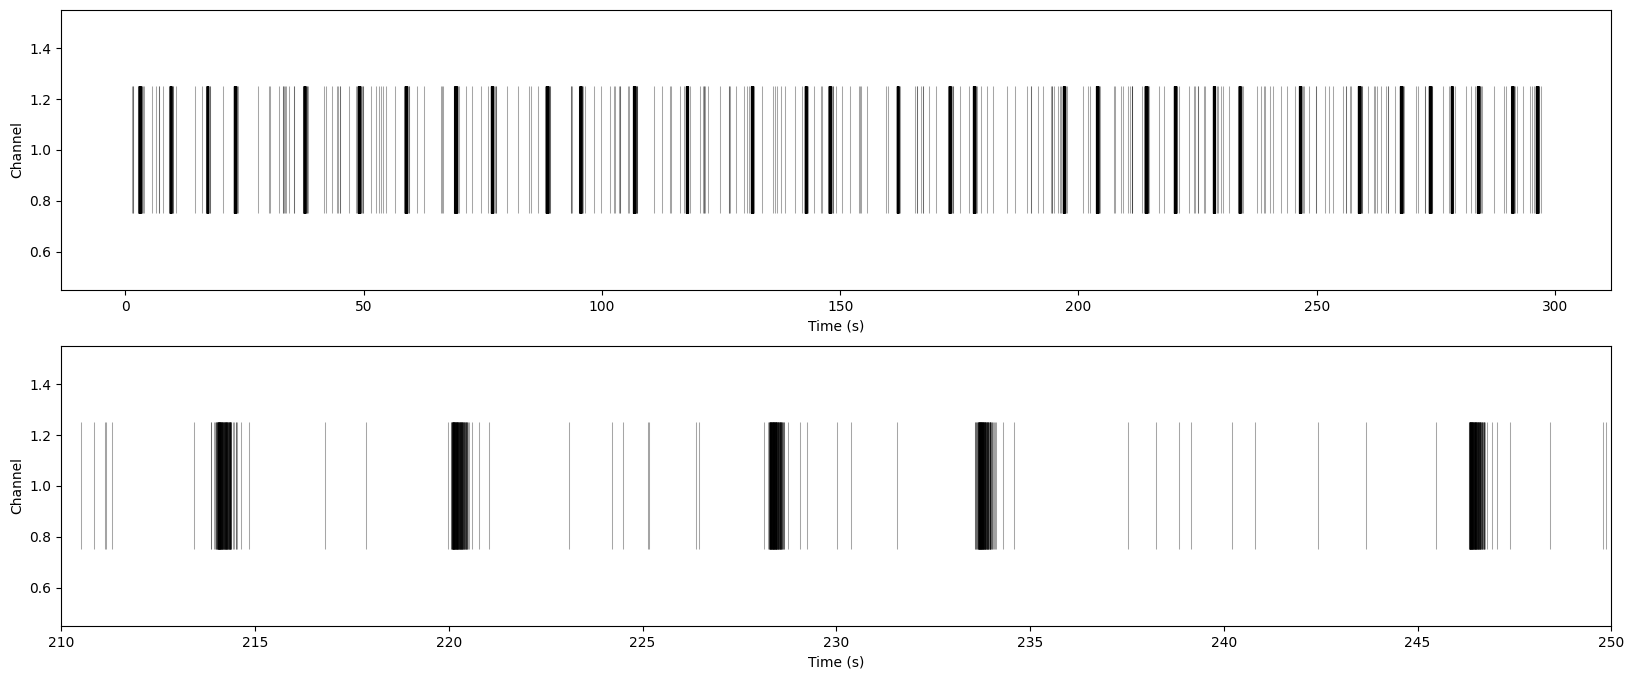

In [ ]:
f = plt.figure(figsize=(20, 8), constrained_layout=False)
grid = f.add_gridspec(2, 3)
plt.subplot(grid[0,0:3])
plt.eventplot(spiketrain["Time (s)"], color='black', linelengths=0.5, linewidths=0.75, alpha=0.35)
plt.ylabel("Channel")

plt.subplot(grid[1,0:3])
plt.eventplot(spiketrain["Time (s)"], color='black', linelengths=0.5, linewidths=0.75, alpha=0.35)
plt.xlabel("Time (s)")
plt.ylabel("Channel")
plt.xlim([210,250])

## Max Interval Burst Detection
A Python- based Max Interval (MI) burst detection algorithm was created to identify individual bursts. MI is a fixed threshold-based method for identifying bursts that uses five fixed threshold parameters (maximum ISI at start of the burst, maximum ISI in burst, minimum burst duration, minimum IBI, and minimum number of spikes within burst) to identify, merge, and exclude potential bursts. The values for these parameters are chosen a priori.

In [ ]:
def maxInterval(spiketrain, max_begin_ISI=0.17, max_end_ISI=0.3, min_IBI=0.2, min_burst_duration=0.01,
                min_spikes_in_burst=3):
    allBurstData = {}

    '''
    Phase 1 - Burst Detection
    Here a burst is defined as starting when two consecutive spikes have an
    ISI less than max_begin_ISI apart. The end of the burst is given when two
    spikes have an ISI greater than max_end_ISI.
    Find ISIs closer than max_begin_ISI and end with max_end_ISI.
    The last spike of the previous burst will be used to calculate the IBI.
    For the first burst, there is no previous IBI.
    '''
    inBurst = False
    burstNum = 0
    currentBurst = []
    for n in range(1, len(spiketrain)):
        ISI = spiketrain[n] - spiketrain[n - 1]
        if inBurst:
            if ISI > max_end_ISI:  # end the burst
                currentBurst = np.append(currentBurst, spiketrain[n - 1])
                allBurstData[burstNum] = currentBurst
                currentBurst = []
                burstNum += 1
                inBurst = False
            elif (ISI < max_end_ISI) & (n == len(spiketrain) - 1):
                currentBurst = np.append(currentBurst, spiketrain[n])
                allBurstData[burstNum] = currentBurst
                burstNum += 1
            else:
                currentBurst = np.append(currentBurst, spiketrain[n - 1])
        else:
            if ISI < max_begin_ISI:
                currentBurst = np.append(currentBurst, spiketrain[n - 1])
                inBurst = True
    # Calculate IBIs
    IBI = []
    for b in range(1, burstNum):
        prevBurstEnd = allBurstData[b - 1][-1]
        currBurstBeg = allBurstData[b][0]
        IBI = np.append(IBI, (currBurstBeg - prevBurstEnd))

    '''
    Phase 2 - Merging of Bursts
    Here we see if any pair of bursts have an IBI less than min_IBI; if so,
    we then merge the bursts. We specifically need to check when say three
    bursts are merged into one.
    '''
    tmp = allBurstData
    allBurstData = {}
    burstNum = 0
    for b in range(1, len(tmp)):
        prevBurst = tmp[b - 1]
        currBurst = tmp[b]
        if IBI[b - 1] < min_IBI:
            prevBurst = np.append(prevBurst, currBurst)
        allBurstData[burstNum] = prevBurst
        burstNum += 1
    if burstNum >= 2:
        allBurstData[burstNum] = currBurst

    '''
    Phase 3 - Quality Control
    Remove small bursts less than min_bursts_duration or having too few
    spikes less than min_spikes_in_bursts. In this phase we have the
    possibility of deleting all spikes.
    '''
    tooShort = 0
    tmp = allBurstData
    allBurstData = {}
    burstNum = 0
    if len(tmp) > 1:
        for b in range(len(tmp)):
            currBurst = tmp[b]
            if len(currBurst) <= min_spikes_in_burst:
                tooShort +=1
            elif currBurst[-1] - currBurst[0] <= min_burst_duration:
                tooShort += 1
            else:
                allBurstData[burstNum] = currBurst
                burstNum += 1

    return allBurstData, tooShort



## Detect Bursts

In [ ]:
allBurstData, _ = maxInterval(spiketrain["Time (s)"].values)

In [ ]:
print(f"MaxInterval detected {len(allBurstData)} bursts.")

MaxInterval detected 35 bursts.


## Plot the results

(210.0, 250.0)

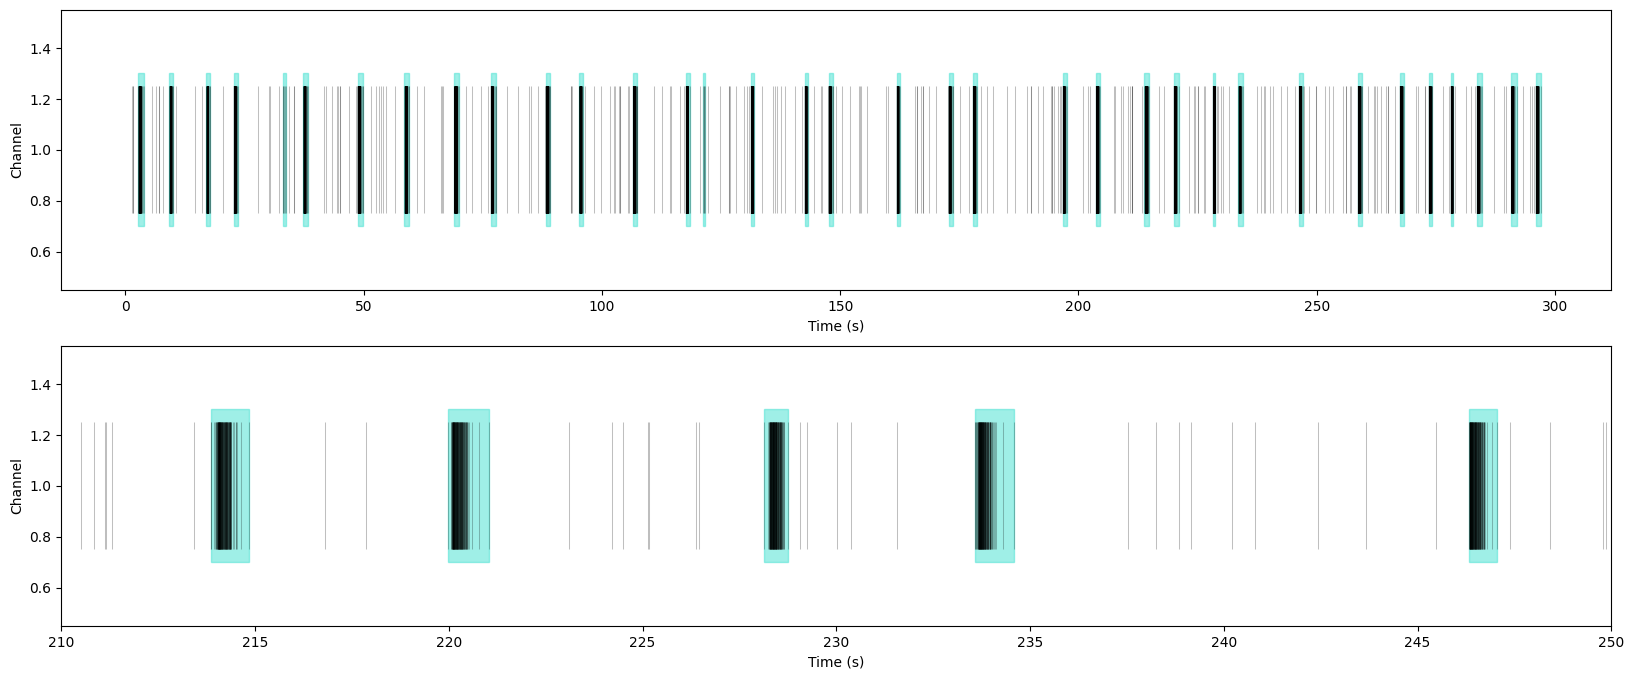

In [ ]:
f = plt.figure(figsize=(20, 8), constrained_layout=False)
grid = f.add_gridspec(2, 3)
plt.subplot(grid[0,0:3])
plt.eventplot(spiketrain["Time (s)"], color='black', linelengths=0.5, linewidths=0.75, alpha=0.25)
for b in allBurstData:
    burst_start = allBurstData[b][0]
    burst_duration = allBurstData[b][-1]-burst_start
    rect = Rectangle((burst_start, 0.7), burst_duration, 0.6, alpha=0.5, edgecolor='turquoise', facecolor='turquoise')
    plt.gca().add_patch(rect)
plt.ylabel("Channel")

plt.subplot(grid[1,0:3])
plt.eventplot(spiketrain["Time (s)"], color='black', linelengths=0.5, linewidths=0.75, alpha=0.25)
for b in allBurstData:
    burst_start = allBurstData[b][0]
    burst_duration = allBurstData[b][-1]-burst_start
    rect = Rectangle((burst_start, 0.7), burst_duration, 0.6, alpha=0.5, edgecolor='turquoise', facecolor='turquoise')
    plt.gca().add_patch(rect)
plt.xlabel("Time (s)")
plt.ylabel("Channel")
plt.xlim([210,250])


## Calculate some basic burst features




In [ ]:
# Inter-burst-interval
ibi = []
for b in range(len(allBurstData)-1):
  ibi.append(allBurstData[b+1][0]-allBurstData[b][-1])

# Burst duration
duration = [allBurstData[b][-1]-allBurstData[b][0] for b in range(len(allBurstData))]

Text(0, 0.5, 'Count')

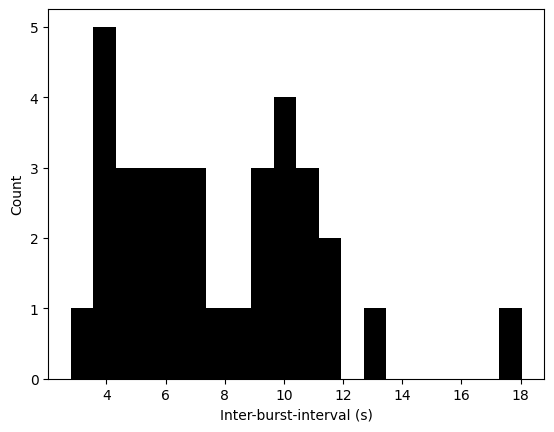

In [ ]:
plt.hist(ibi, bins=20, color='black')
plt.xlabel("Inter-burst-interval (s)")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

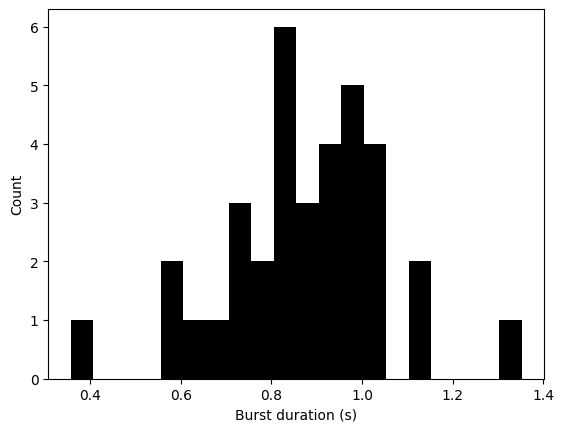

In [ ]:
plt.hist(duration, bins=20, color='black')
plt.xlabel("Burst duration (s)")
plt.ylabel("Count")